# Project 3 (Women's Clothing Reviews Sentiment Analysis - NLP)

This notebook demonstrates the application of introductory natural language processing techniques to an e-commerce customer reviews dataset, focusing on:

1) Text data understanding
2) Text preprocessing and representation
3) Basic sentiment modelling and evaluation

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Womens Clothing E-Commerce Reviews - NLP

In [4]:
df = pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [5]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [6]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

The tagging of the target variable is inaccurate, but I'm about to use it as is.

## Text Features:

In [7]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


## Merging text features:

In [8]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


## Dropping null values

In [9]:
text_df.Review.isna().sum()

np.int64(3811)

In [10]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


## Target Value - positive\negative review

In [11]:
text_df['Recommended'].unique()

array([0, 1])

In [12]:
text_df['Recommended'].value_counts(normalize=True)

,proportion
Recommended,
1,0.818297
0,0.181703


The target is imbalanced

## Adding Features

Text Length:

In [13]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


In [14]:
text_df['Review_length'].describe()

,Review_length
count,19675.000000
mean,338.450267
std,144.740126
min,23.000000
25%,217.000000
50%,336.000000
75%,496.000000
max,557.000000


<Axes: xlabel='Review_length', ylabel='Density'>

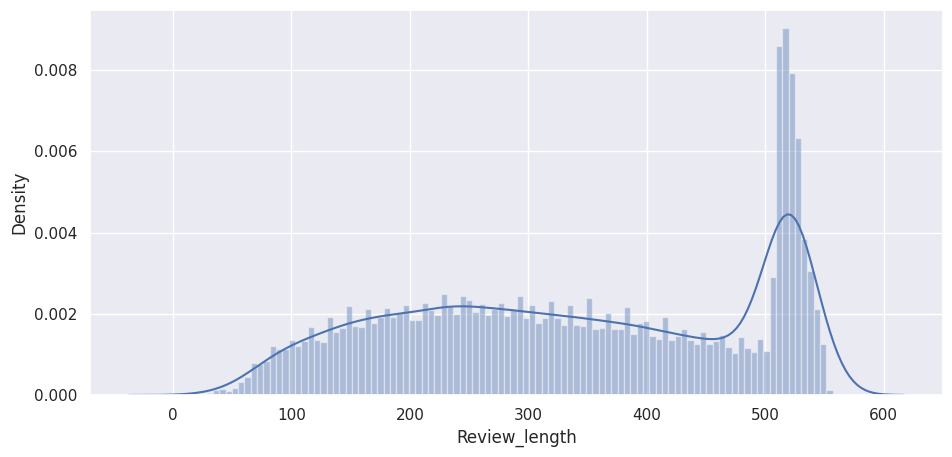

In [15]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

In [16]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

<Axes: ylabel='Density'>

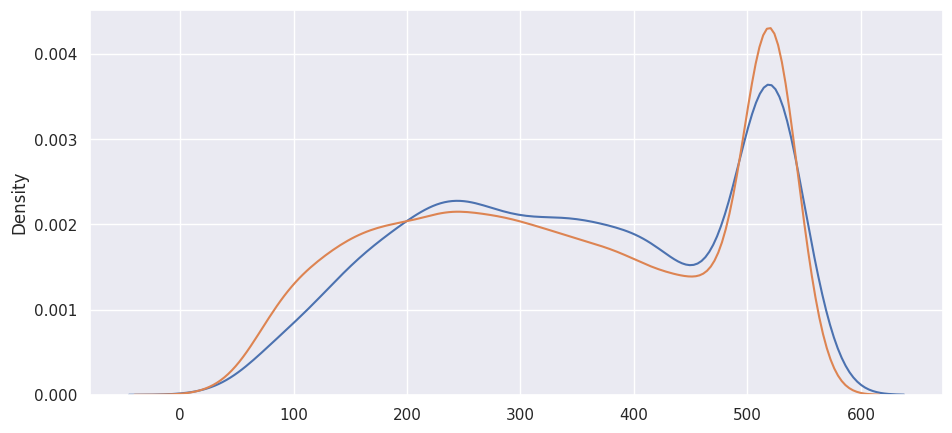

In [17]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

Exclamation mark counter:

In [18]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [19]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


In [20]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

,count_exc
count,19675.000000
mean,0.883151
std,1.412098
min,0.000000
20%,0.000000
40%,0.000000
50%,0.000000
60%,1.000000
80%,2.000000
max,41.000000


<Axes: xlabel='count_exc'>

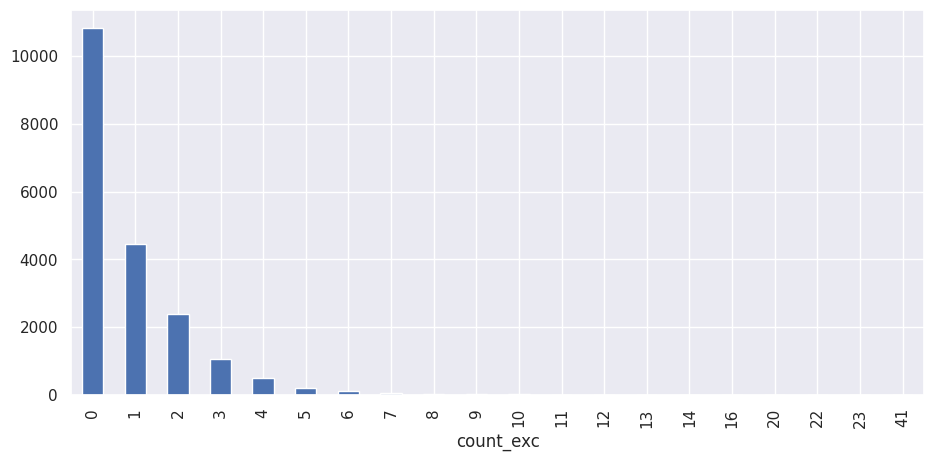

In [21]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [22]:
text_df[text_df['count_exc']== 41].index

Index([3301], dtype='int64')

In [23]:
text_df['Review'][3301]

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

## Text Polarity

Polarity is the emotion expressed in the sentence. It can be positive, neagtive and neutral.

The polarity score is a float within the range [-1.0, 1.0]

In [24]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


<Axes: ylabel='Frequency'>

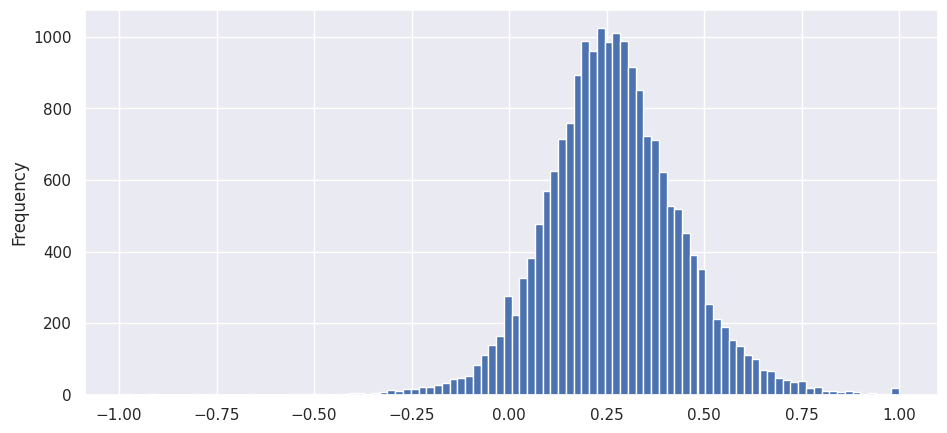

In [25]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [26]:
text_prep = text_df.copy()

___

## Preprocessing - text features

Dropping punctuation

In [27]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [29]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

,Review
2,Some major design flaws I had such high hopes ...
3,My favorite buy I love love love this jumpsuit...
4,Flattering shirt This shirt is very flattering...
5,Not for the very petite I love tracy reese dre...
6,Cagrcoal shimmer fun I aded this in my basket ...


## Part of Speech filter:

Mostly adjectives and verbs reflect the positiveness or negativeness of the reviews

In [30]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=10)

In [31]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])
    return ' '.join(new_string)

In [32]:
text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

,Review
2,major had such high wanted work i ordered smal...
3,favorite love love fabulous wear i get great
4,Flattering is flattering due adjustable is per...
5,petite love reese is petite am tall wear was i...
6,aded last see look i went am pale is gorgeous ...
7,goes ordered had try used top pair went is nic...
8,Flattering love get runs little ordered flatte...


## Stopwords:

In [33]:
print(stopwords.words('english')[::12])

['a', 'are', 'both', 'doesn', 'had', "he'll", 'if', 'its', 'mustn', 'off', 're', "should've", 'themselves', 'to', "we'll", 'whom', 'your']


In [34]:
stop = stopwords.words('english')
stop.append("i'm")

Stopwords punctuation removal

In [35]:
stop_words = []

for item in stop:
    new_item = punctuation_removal(item)
    stop_words.append(new_item)
print(stop_words[::12])

['a', 'are', 'both', 'doesn', 'had', 'hell', 'if', 'its', 'mustn', 'off', 're', 'shouldve', 'themselves', 'to', 'well', 'whom', 'your']


adding clothing stopwords:

In [36]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [37]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [38]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

,Review
2,"[major, high, wanted, work, ordered, small, us..."
3,"[favorite, love, love, fabulous, get, great]"
4,"[flattering, flattering, due, adjustable, perf..."
5,"[petite, love, reese, petite, tall, long, full..."
6,"[aded, last, see, look, went, pale, gorgeous, ..."


In [39]:
print(text_prep['Review'][3301])

#'Beautiful and unique. Love this top, just received it today.
# \nit is a very artistic interpretation for a casual top.
# \nthe blue is gorgeous!
# \nthe unique style of the peplm and the details on the front set this apart!
# \nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.
# \nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nordered my usual size and it fits perfectly.'

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']


In [40]:
print(text_prep['Review'][267])

['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


## Removing all numbers (weight, size etc.)

In [41]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [42]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

,Review
2,major high wanted work ordered small usual fou...
3,favorite love love fabulous get great
4,flattering flattering due adjustable perfect p...
5,petite love reese petite tall long full overwh...
6,aded last see look went pale gorgeous turns ma...


In [43]:
print(text_prep['Review'][267])

nice short tall say fits true short tall wish came


In [44]:
print(text_prep['Review'][2293])

flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


## Stemming

In [45]:
porter = PorterStemmer()

In [46]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

,Review
2,"[major, high, wanted, work, ordered, small, us..."
3,"[favorite, love, love, fabulous, get, great]"
4,"[flattering, flattering, due, adjustable, perf..."
5,"[petite, love, reese, petite, tall, long, full..."
6,"[aded, last, see, look, went, pale, gorgeous, ..."


In [47]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word)
    return text_list_new

In [48]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

,Review
2,"[major, high, want, work, order, small, usual,..."
3,"[favorit, love, love, fabul, get, great]"
4,"[flatter, flatter, due, adjust, perfect, pair,..."
5,"[petit, love, rees, petit, tall, long, full, o..."
6,"[ade, last, see, look, went, pale, gorgeou, tu..."


In [49]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

,Review
2,major high want work order small usual found s...
3,favorit love love fabul get great
4,flatter flatter due adjust perfect pair cardigan
5,petit love rees petit tall long full overwhelm...
6,ade last see look went pale gorgeou turn mathc...


In [50]:
print(text_prep['Review'][2293])

flatter purchas return expect fit said lb got get disappoint soft purchas regular fit look terribl say tall thin ye short petit


## WordCloud - Repetition of words

In [51]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,favorit love love fabul get great,141,3,0.560714
4,1,flatter flatter due adjust perfect pair cardigan,209,3,0.512891
6,1,ade last see look went pale gorgeou turn mathc...,517,0,0.157500


In [52]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review)
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

## Positive reviews

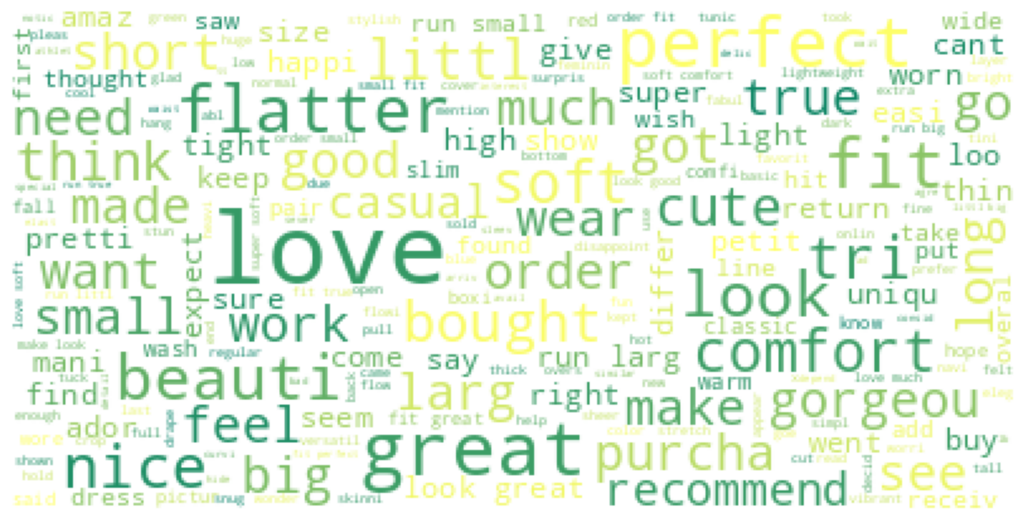

In [53]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Negative Reviews:

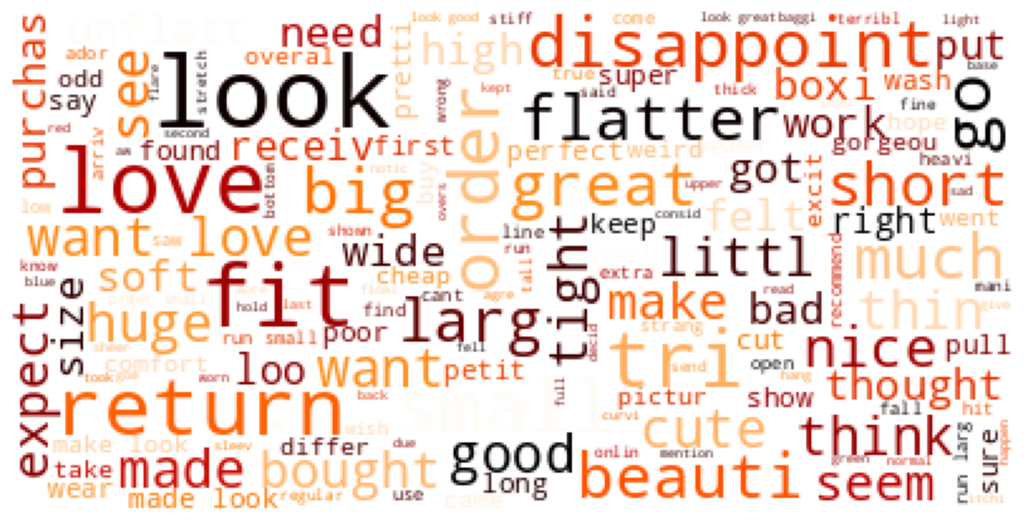

In [54]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Pay attention to the words: return, disappoint, small

## Vectorising - Bag of Words

In [55]:
text_prep['Review'].head()

,Review
2,major high want work order small usual found s...
3,favorit love love fabul get great
4,flatter flatter due adjust perfect pair cardigan
5,petit love rees petit tall long full overwhelm...
6,ade last see look went pale gorgeou turn mathc...


In [56]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [57]:
bow_transformer = CountVectorizer(tokenizer=text_vectorizing_process)

In [58]:
bow_transformer.fit(text_prep['Review'])

CountVectorizer(tokenizer=<function text_vectorizing_process at 0x7c8339b89260>)

In [59]:
print(text_prep['Review'].iloc[3])

petit love rees petit tall long full overwhelm small shorten narrow take love work return


In [60]:
example = bow_transformer.transform([text_prep['Review'].iloc[3]])
print(example)
#3507=Love
#4438=petit

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 13 stored elements and shape (1, 7284)>
  Coords	Values
  (0, 2421)	1
  (0, 3443)	1
  (0, 3512)	2
  (0, 3887)	1
  (0, 4308)	1
  (0, 4445)	2
  (0, 4884)	1
  (0, 5013)	1
  (0, 5392)	1
  (0, 5610)	1
  (0, 6204)	1
  (0, 6209)	1
  (0, 7165)	1


In [61]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 237068 stored elements and shape (19675, 7284)>

In [62]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

Shape of Sparse Matrix (19675, 7284)
Amount of Non-Zero occurences: 237068


## TF-IDF

Term Frequency–Inverse Document Frequency

In [63]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)
#3507=Love
#4438=petit

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13 stored elements and shape (1, 7284)>
  Coords	Values
  (0, 2421)	0.24031723766411767
  (0, 3443)	0.2025023654276937
  (0, 3512)	0.21175884431125433
  (0, 3887)	0.3072123012448638
  (0, 4308)	0.3214748504588951
  (0, 4445)	0.40654095314966315
  (0, 4884)	0.3931489310865169
  (0, 5013)	0.18887129921996426
  (0, 5392)	0.35525242967975695
  (0, 5610)	0.14429416062935618
  (0, 6204)	0.23651711293793254
  (0, 6209)	0.2570248132639301
  (0, 7165)	0.18474832182622422


In [64]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]

[('loungeathom', 3507)]

In [65]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('usual', 6818),
 ('tight', 6387),
 ('great', 2612),
 ('full', 2421),
 ('went', 7045),
 ('jkeep', 3153)]

In [66]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

(19675, 7284)

In [67]:
print(messages_tfidf[:1])
#tuple(index_num, word_num), tfidf_proba

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22 stored elements and shape (1, 7284)>
  Coords	Values
  (0, 700)	0.17821608397814717
  (0, 879)	0.25041287583724675
  (0, 987)	0.18586860584229017
  (0, 1156)	0.10286902108319058
  (0, 2202)	0.08244245717631357
  (0, 2369)	0.1457720140690415
  (0, 2776)	0.14141012157006996
  (0, 2939)	0.3012448744762283
  (0, 3589)	0.5083284096979694
  (0, 3950)	0.29428842992081033
  (0, 4144)	0.20235563539957674
  (0, 4216)	0.09698403174343508
  (0, 4266)	0.15352922933973667
  (0, 4445)	0.1354104542999117
  (0, 4952)	0.23665459787700197
  (0, 5299)	0.1824517693965319
  (0, 5610)	0.28836855464033695
  (0, 6387)	0.13612658433639602
  (0, 6818)	0.1465184919443577
  (0, 6937)	0.11634380296424818
  (0, 7165)	0.12307175449763683
  (0, 7280)	0.2078850962788002


## Merging Sparse matrix with other features

In [68]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

(19675, 7284)


,0,1,2,3,4,5,6,7,8,9,...,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.207885,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [69]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf,
                  left_index=True, right_index=True )
df_all.head()

,Recommended,Review_length,count_exc,Polarity,0,1,2,3,4,5,...,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283
2,0,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting the data

In [70]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283
2,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
X.shape

(16481, 7287)

In [72]:
X.describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283
count,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.0,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,338.411261,0.876221,0.265987,0.000024,0.000030,0.000024,0.0,0.000049,0.000021,0.000020,...,0.000023,0.000025,0.000076,0.000048,0.000054,0.000021,0.002121,0.000315,0.000030,0.000125
std,144.790275,1.414203,0.172803,0.003139,0.003794,0.003098,0.0,0.004483,0.002747,0.002549,...,0.002950,0.003207,0.004952,0.004398,0.004935,0.002727,0.027439,0.010892,0.003799,0.007291
min,23.000000,0.000000,-0.987500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,0.000000,0.158333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,335.000000,0.000000,0.260863,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,497.000000,1.000000,0.370312,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,557.000000,41.000000,1.000000,0.402938,0.487124,0.397730,0.0,0.447529,0.352600,0.327234,...,0.378710,0.411733,0.382191,0.400114,0.496872,0.350060,0.629020,0.484828,0.487690,0.526867


In [73]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11536, 7287), (4945, 7287), (11536,), (4945,))

In [74]:
y_train.value_counts(normalize=True)

,proportion
Recommended,
1,0.818741
0,0.181259


In [75]:
y_test.value_counts(normalize=True)

,proportion
Recommended,
1,0.818605
0,0.181395


## Scaler - MinMaxScaler

In [76]:
scaler = MinMaxScaler()
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283
count,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,...,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.00000,11536.0,11536.000000
mean,0.587341,0.021667,0.631576,0.000087,0.000087,0.000087,0.0,0.000087,0.000087,0.000087,...,0.000087,0.0,0.000285,0.000087,0.000155,0.000087,0.003278,0.00068,0.0,0.000340
std,0.272417,0.035310,0.087348,0.009310,0.009310,0.009310,0.0,0.009310,0.009310,0.009310,...,0.009310,0.0,0.015486,0.009310,0.011872,0.009310,0.043159,0.02321,0.0,0.016539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
25%,0.357678,0.000000,0.577737,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
50%,0.578652,0.000000,0.628931,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
75%,0.885768,0.024390,0.683922,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,1.000000


## Data Visualization (PCA)

In [78]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[ 0.13579856, -0.09433352]])

<Axes: >

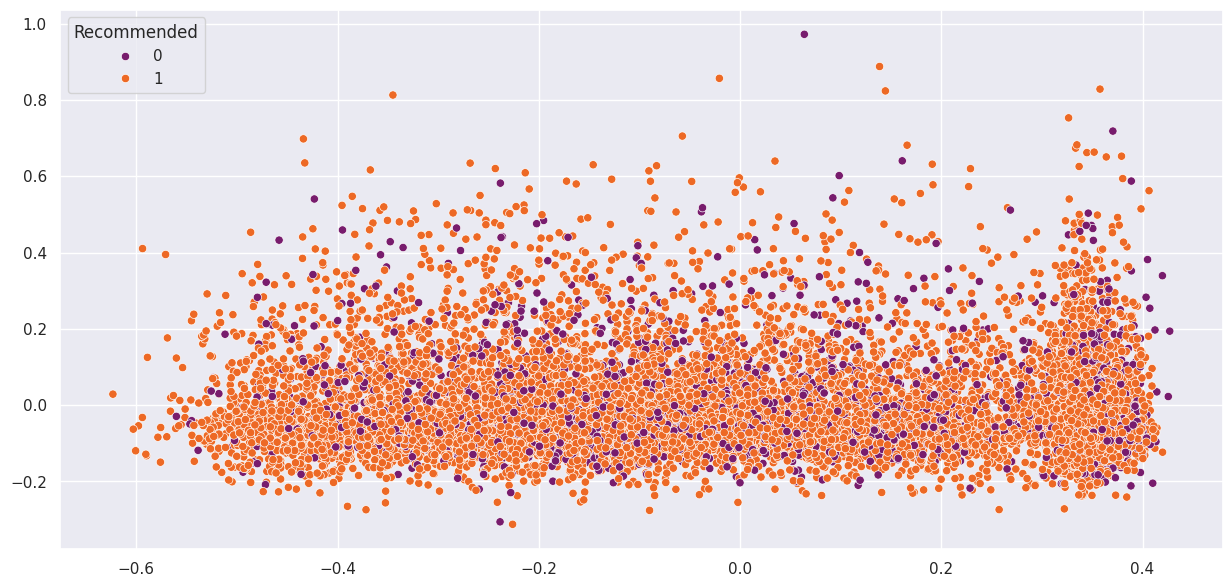

In [79]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0],
                y=X_train_scaled_pca[:, 1],
                hue=y_train,
                sizes=100,
                palette="inferno")

In [80]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)

## Models

In [81]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred),
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

Model Evaluation will be made by two metrics:
1. <u> F1 micro score</u>  - which is the harmonic mean of precision and recall, and takes into account label imbalances.
2. <u> AUC </u>- ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.


## 1. Logistic Regression

In [82]:
lr_model = LogisticRegression(class_weight='balanced',
                              random_state=111,
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model,
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]},
                           cv=5,
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [83]:
gs_lr_model.best_params_

{'C': 0.1}

In [84]:
test_predictions = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions, gs_lr_model.classes_ ))

Confusion Matrix:
      0     1
0   618   279
1  1104  2944

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.69      0.47       897
           1       0.91      0.73      0.81      4048

    accuracy                           0.72      4945
   macro avg       0.64      0.71      0.64      4945
weighted avg       0.81      0.72      0.75      4945



<Axes: title={'center': 'ROC Curves - Logistic Regression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

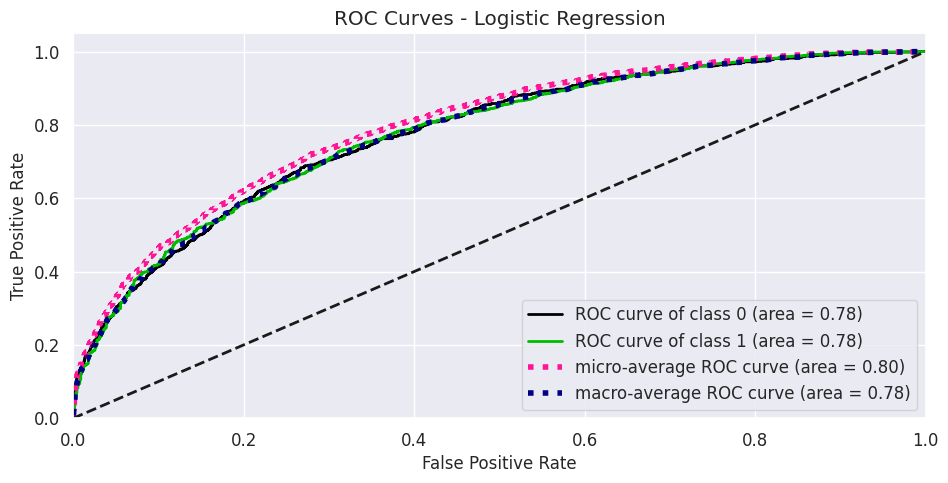

In [85]:
skplt.metrics.plot_roc(y_test, gs_lr_model.predict_proba(X_test_scaled),
                      title='ROC Curves - Logistic Regression')

## 2. Random Forest

In [86]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5,
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       random_state=3)

In [87]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))

Confusion Matrix:
     0     1
0  530   367
1  804  3244

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.59      0.48       897
           1       0.90      0.80      0.85      4048

    accuracy                           0.76      4945
   macro avg       0.65      0.70      0.66      4945
weighted avg       0.81      0.76      0.78      4945



<Axes: title={'center': 'ROC Curves - Random Forest'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

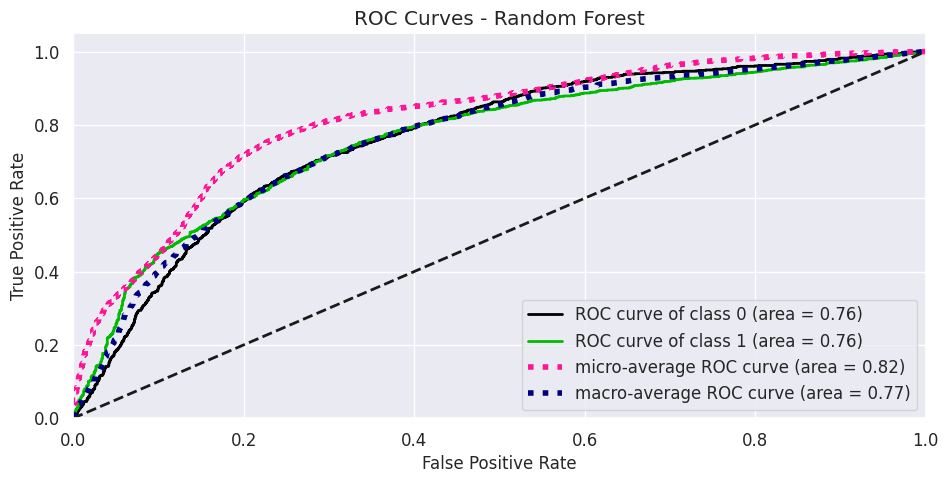

In [88]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test),
                       title='ROC Curves - Random Forest')

In [89]:
my_list = list(zip(rf_model.feature_importances_ ,X.columns))
my_list.sort(key=lambda tup: tup[0],reverse=True)
my_list[:7]

[(np.float64(0.06489568286447964), 'Polarity'),
 (np.float64(0.050794239214283284), 'count_exc'),
 (np.float64(0.026716338635992966), 'Review_length'),
 (np.float64(0.010509723479436734), 3527),
 (np.float64(0.010344037934986321), 3470),
 (np.float64(0.009479966326229284), 2552),
 (np.float64(0.00785224176635519), 2421)]

In [90]:
bow_list = [i for i in bow_transformer.vocabulary_.items()]

for i in my_list:
    for j in bow_list:
        if i[1] == j[1] and i[0]> 0.005:
            print(f'Importance: {i[0]:.4f}   Word num: {i[1]}   Word:  { j[0]}')

Importance: 0.0105   Word num: 3527   Word:  low
Importance: 0.0103   Word num: 3470   Word:  look
Importance: 0.0095   Word num: 2552   Word:  good
Importance: 0.0079   Word num: 2421   Word:  full
Importance: 0.0062   Word num: 1608   Word:  differ
Importance: 0.0061   Word num: 5107   Word:  run
Importance: 0.0061   Word num: 765   Word:  bright
Importance: 0.0060   Word num: 4841   Word:  receiv
Importance: 0.0055   Word num: 2369   Word:  found
Importance: 0.0055   Word num: 2046   Word:  extra
Importance: 0.0054   Word num: 176   Word:  amaz
Importance: 0.0052   Word num: 2202   Word:  fit
Importance: 0.0052   Word num: 6547   Word:  tuck
Importance: 0.0051   Word num: 4150   Word:  old
Importance: 0.0050   Word num: 3512   Word:  love


## Random Forest - Threshold:

In [91]:
probs = rf_model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, probs[:,1])

Text(0, 0.5, 'TPR')

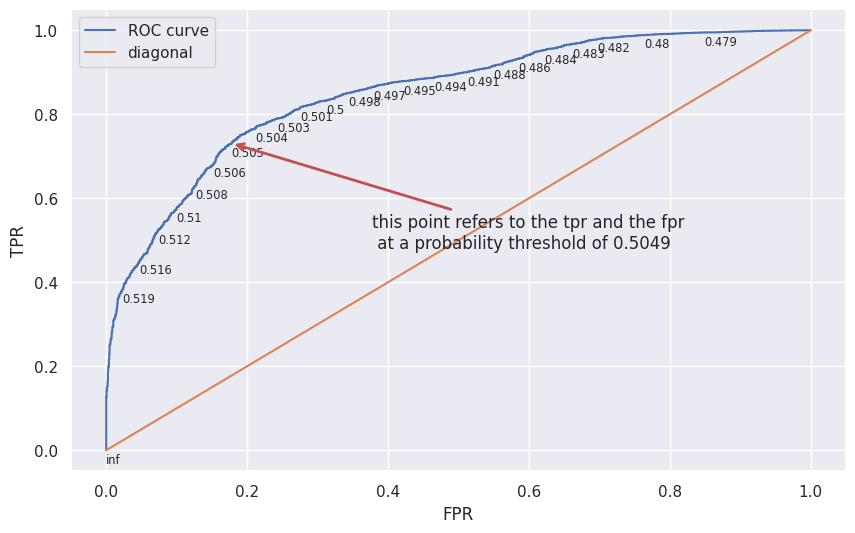

In [92]:
#Train
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
    plt.annotate(np.round(txt,3), (x, y-0.03), fontsize='x-small')
rnd_idx = 700
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'\
             .format(np.round(thresholds[rnd_idx], 4)),
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->',color='r'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [93]:
probs = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])

Text(0, 0.5, 'TPR')

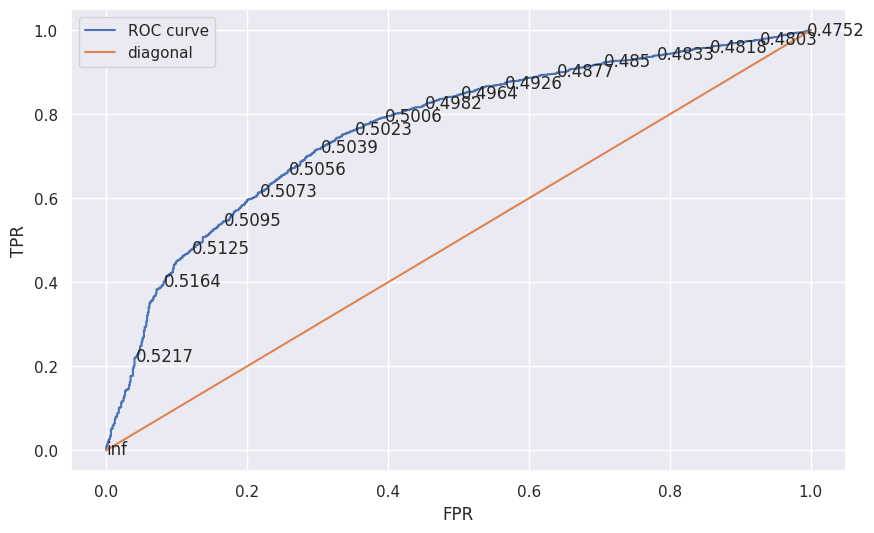

In [94]:
#Test
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::70], tpr[::70], thresholds[::70]):
    plt.annotate(np.round(txt,4), (x, y-0.01))

plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

* Logistic Regression - f1 micro score of 0.72
* Random Forest - f1 micro score of 0.76


In [95]:
X_train = pd.DataFrame(X_train.toarray(), columns=X.columns)
X_train.columns = X_train.columns.astype(str)
X_train.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283
0,406.0,2.0,0.158373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,473.0,0.0,0.065000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,332.0,0.0,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,246.0,0.0,0.370000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,243.0,1.0,0.138036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
X_test = pd.DataFrame(X_test.toarray(), columns=X.columns)
X_test.columns = X_test.columns.astype(str)
X_test.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283
0,297.0,0.0,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,125.0,0.0,0.157143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,384.0,0.0,0.189610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,255.0,0.0,0.387500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,329.0,4.0,0.341220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
rf_model.classes_

array([0, 1])

In [98]:
arr= rf_model.predict_proba(X_test)
print(arr)

[[0.49580931 0.50419069]
 [0.51074102 0.48925898]
 [0.50042467 0.49957533]
 ...
 [0.48076203 0.51923797]
 [0.49948442 0.50051558]
 [0.51378497 0.48621503]]


In [99]:
arr_list = arr.tolist()

In [100]:
arr_list[1][1]

0.48925898380263283

In [101]:
proba_list = []
for i in arr_list:
    proba_list.append(i[0])
proba_list[:5]

[0.49580930740338935,
 0.5107410161974291,
 0.5004246740259608,
 0.4952438097264497,
 0.47957520463157993]

In [102]:
X_test['Proba0'] = proba_list
X_test.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7275,7276,7277,7278,7279,7280,7281,7282,7283,Proba0
0,297.0,0.0,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495809
1,125.0,0.0,0.157143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510741
2,384.0,0.0,0.189610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500425
3,255.0,0.0,0.387500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495244
4,329.0,4.0,0.341220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.479575


In [103]:
prediction_list = []
for i in X_test['Proba0']:
    if i > 0.4998:
        prediction_list.append(0)
    else:
        prediction_list.append(1)
prediction_list[:5]

[1, 0, 0, 1, 1]

In [104]:
X_test['Predictions'] = prediction_list
X_test.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7276,7277,7278,7279,7280,7281,7282,7283,Proba0,Predictions
0,297.0,0.0,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495809,1
1,125.0,0.0,0.157143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510741,0
2,384.0,0.0,0.189610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500425,0
3,255.0,0.0,0.387500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495244,1
4,329.0,4.0,0.341220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.479575,1


In [105]:
print(report(y_test, X_test['Predictions'], rf_model.classes_))

Confusion Matrix:
     0     1
0  533   364
1  817  3231

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.59      0.47       897
           1       0.90      0.80      0.85      4048

    accuracy                           0.76      4945
   macro avg       0.65      0.70      0.66      4945
weighted avg       0.81      0.76      0.78      4945

